In [1]:
import tensorflow as tf
tf.enable_eager_execution()

!sudo rm -f /etc/boto.cfg
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

import saving_train
import loading_ds_train

import loading_ds_test
import saving_test

In [2]:
## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


In [3]:
## Optional: remove sliced images from directory if necessary
!rm -r 'data'
# !rm -r 'data/094'

In [4]:
training_image_path_list = ['tumor_094.tif',
                            'tumor_091.tif',
                            'tumor_031.tif',
                            'tumor_078.tif',
                            'tumor_081.tif',
                            'tumor_064.tif',
                            'tumor_035.tif',
                            'tumor_075.tif',
                            'tumor_019.tif',
                            'tumor_084.tif',
                            'tumor_012.tif',
                            'tumor_059.tif',
                            'tumor_101.tif',
                            'tumor_023.tif',
                            'tumor_005.tif',
                            'tumor_110.tif']

# validation_image_path_list = ['tumor_101.tif',
#                               'tumor_023.tif',
#                               'tumor_091.tif',
#                               'tumor_110.tif']

testing_image_path_list = ['tumor_094.tif',
                           'tumor_016.tif',
                           'tumor_078.tif',
                           'tumor_096.tif',]

In [5]:
saving_train.train_part_1(training_image_path_list, num_pixels = 64, num_level = 3)

tumor_094.tif tumor_094_mask.tif
tumor_091.tif tumor_091_mask.tif
tumor_031.tif tumor_031_mask.tif
tumor_078.tif tumor_078_mask.tif
tumor_081.tif tumor_081_mask.tif
tumor_064.tif tumor_064_mask.tif
tumor_035.tif tumor_035_mask.tif
tumor_075.tif tumor_075_mask.tif
tumor_019.tif tumor_019_mask.tif
tumor_084.tif tumor_084_mask.tif
tumor_012.tif tumor_012_mask.tif
tumor_059.tif tumor_059_mask.tif
tumor_101.tif tumor_101_mask.tif
tumor_023.tif tumor_023_mask.tif
tumor_091.tif tumor_091_mask.tif
tumor_110.tif tumor_110_mask.tif


In [6]:
saving_train.save_second_level(training_image_path_list, input_level = 3, num_input_pixels = 64, 
                                                       output_level = 4, num_output_pixels = 64)

In [7]:
ds_train, steps_per_epoch_train = loading_ds_train.train_part_2(training_image_path_list, num_level_1 = 3,num_level_2=4 )

In [8]:
print(steps_per_epoch_train)

5787


In [9]:
## Imagenet bases using model subclassing
class dense_conv_split_model(tf.keras.Model):

    def __init__(self):
        super(dense_conv_split_model, self).__init__(name='dense_conv_split_model')

        conv_base = tf.keras.applications.VGG16(weights='imagenet',include_top=False) #,
                                                #input_shape=(128, 128, 3))
            
#         conv_base = tf.keras.applications.xception.Xception(include_top=False,
#                                                         weights='imagenet',
#                                                         classes=2)

            
            
        conv_base.trainable = False

        self.cnn1 = conv_base
        self.model1_flatten1  = tf.keras.layers.Flatten()

        self.cnn2 = conv_base
        self.model2_flatten2 = tf.keras.layers.Flatten()

        self.merge_layer = tf.layers.Dense(32, activation='relu')
        self.final = tf.layers.Dense(2, activation='softmax')

    def call(self, x):
        x1, x2 = x[0], x[1]

        x1 = self.cnn1(x1)
        x1 = self.model1_flatten1(x1)

        x2 = self.cnn2(x2)
        x2 = self.model2_flatten2(x2)

        x = tf.concat([x1, x2], 1)
        x = self.merge_layer(x)
        x = self.final(x)

        return x

In [10]:
model = dense_conv_split_model()

In [11]:
## Compile and train model
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

history = model.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch_train)

Epoch 1/10
5787/5787 [==============================] - 979s 169ms/step - loss: 0.3255 - acc: 0.8832
Epoch 2/10
5787/5787 [==============================] - 972s 168ms/step - loss: 0.2170 - acc: 0.9179
Epoch 3/10
5787/5787 [==============================] - 973s 168ms/step - loss: 0.1903 - acc: 0.9267
Epoch 4/10
5787/5787 [==============================] - 973s 168ms/step - loss: 0.1703 - acc: 0.9362
Epoch 5/10
5787/5787 [==============================] - 972s 168ms/step - loss: 0.1589 - acc: 0.9386
Epoch 6/10
5787/5787 [==============================] - 972s 168ms/step - loss: 0.1469 - acc: 0.9449
Epoch 7/10
5787/5787 [==============================] - 972s 168ms/step - loss: 0.1418 - acc: 0.9475
Epoch 8/10
5787/5787 [==============================] - 972s 168ms/step - loss: 0.1307 - acc: 0.9520
Epoch 9/10
5787/5787 [==============================] - 972s 168ms/step - loss: 0.1221 - acc: 0.9543
Epoch 10/10
5787/5787 [==============================] - 972s 168ms/step - loss: 0.1187 - a

In [12]:
# Loading Presaved Weights
model.save_weights('logs/weights_for_presentation')
# model.load_weights('logs/weights_for_presentation')

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  524320    
_________________________________________________________________
dense_2 (Dense)              multiple                  66        
Total params: 15,239,074
Trainable params: 524,386
Non-trainable params: 14,714,688
_________________________________________________________________


{'loss': [0.32554661744073515, 0.21704541421830925, 0.19027882471984967, 0.17029291894442977, 0.15888529751058836, 0.14693243764439248, 0.14183115496519674, 0.13072963634494242, 0.12205280438538674, 0.11865923251169276], 'acc': [0.883229652669777, 0.917919474684638, 0.9266891308104371, 0.9362363919129082, 0.9385692068429238, 0.9449196474857439, 0.94751166407465, 0.9520476931052358, 0.9543373077587697, 0.9559789182650769]}


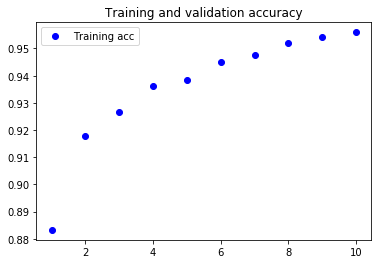

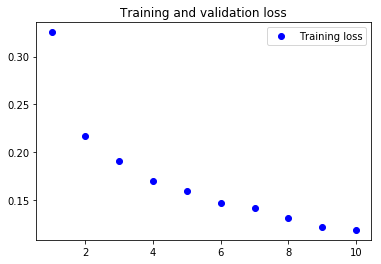

In [14]:
## Plot results
print(history.history)

acc = history.history['acc']
loss = history.history['loss']
# val_acc = history.history['val_loss']
# val_loss = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b-', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Validation

In [15]:
def evaluate(image_path):
    print(image_path)
    image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path,
                                                                                                     num_pixels=64,
                                                                                                     num_level=3)
    saving_test.load_second_level(image_path,
                                  input_level = 3,
                                  num_input_pixels = 64,
                                  output_level = 4,
                                  num_output_pixels = 64)
    
    loading_ds_test.test_part_2(image_path,
                                model,
                                tissue_regions,
                                slide_image_test,
                                tumor_mask,
                                image_depth,
                                image_width,
                                num_level_1 = 3, 
                                num_level_2 = 4)
    

In [29]:
testing_image_path_list = ['tumor_094.tif',
                           'tumor_016.tif',
                           'tumor_078.tif',
                           'tumor_084.tif',]

tumor_094.tif
tumor_094.tif tumor_094_mask.tif
Precision: 0.6118414466183333
Recall: 0.6789441553847083
F1: 0.6436486021520769
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     29824061       399348
Reality 1       297665       629479
           Predicted 0  Predicted 1
Reality 0    95.741674     1.281993
Reality 1     0.955569     2.020763


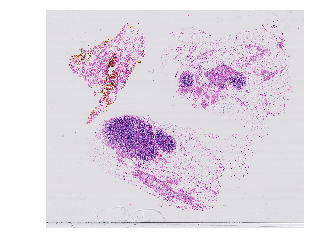

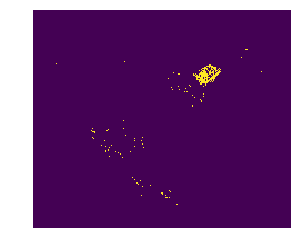

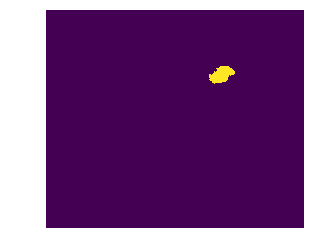

In [30]:
evaluate(testing_image_path_list[0])

tumor_016.tif
tumor_016.tif tumor_016_mask.tif
Precision: 0.8395790964970409
Recall: 0.5682349802623694
F1: 0.6777574101615191
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     13829767       252738
Reality 1      1005057      1322730
           Predicted 0  Predicted 1
Reality 0    84.274960     1.540119
Reality 1     6.124553     8.060368


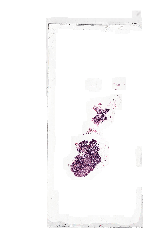

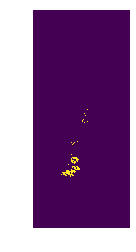

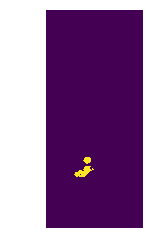

In [20]:
evaluate(testing_image_path_list[1])

tumor_078.tif
tumor_078.tif tumor_078_mask.tif
Precision: 0.8924625786999193
Recall: 0.9377710517299832
F1: 0.9145559967232066
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     33747802      1702837
Reality 1       937776     14131995
           Predicted 0  Predicted 1
Reality 0    66.800333     3.370592
Reality 1     1.856232    27.972843


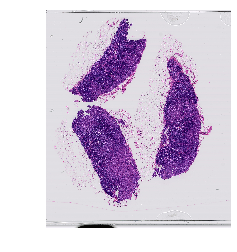

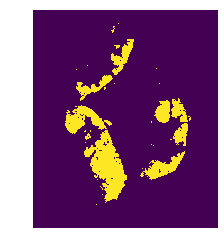

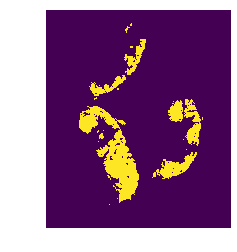

In [23]:
evaluate(testing_image_path_list[2])

tumor_084.tif
tumor_084.tif tumor_084_mask.tif
Precision: 0.520012848195007
Recall: 0.6649332061068702
F1: 0.5836110582616983
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     17006951       295878
Reality 1       161529       320551
           Predicted 0  Predicted 1
Reality 0    95.625741     1.663646
Reality 1     0.908236     1.802376


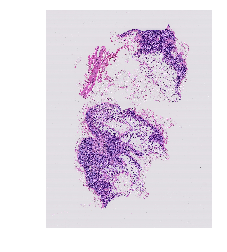

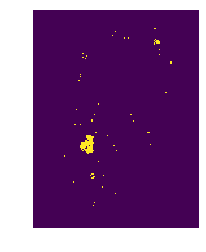

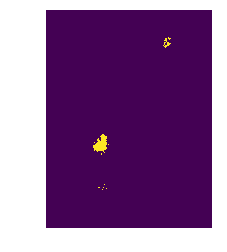

In [26]:
evaluate(testing_image_path_list[3])